# Урок 2. CNN and LSTM for human action recognition

ЗАДАНИЕ 1. Необходимо нормализовать данные в датасете: написать функцию
нормализации и использовать ее внутри класса датасета.

In [1]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
import pandas as pd

use_cuda = torch.cuda.is_available()
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cpu


In [2]:
class LSTM_net(nn.Module):
    def __init__(self,input_dim,hidden_dim,output_dim,layer_num):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.lstm = torch.nn.LSTM(input_dim, hidden_dim,layer_num,batch_first=True)
#         self.dr = torch.nn.Dropout2d(0.25)
        self.fc = torch.nn.Linear(hidden_dim,output_dim)
        
        
    def forward(self,inputs):
        x = inputs
        lstm_out,(hn,cn) = self.lstm(x)
        out = self.fc(lstm_out[:,-1,:])
        return out

In [70]:
def normalize(item):
    maxes=[]  
    ds=pd.DataFrame(item)
    for i in np.arange(len(ds.columns)):
        maxes.append(ds[ds.columns[i]].max())
    
    for row in item:        
        for i in np.arange(len(row)):            
            row[i]= row[i]/maxes[i]            
    return item    
 

In [71]:
item, lab = dataset.__getitem__(41)
res=normalize(item)
res

array([[0.50015664, 0.4083946 , 0.97660759, ..., 0.89284371, 0.2187924 ,
        0.99323678],
       [0.49671513, 0.40795879, 0.97594199, ..., 0.89365083, 0.22629377,
        0.99198288],
       [0.49965549, 0.40815116, 0.97602598, ..., 0.89242997, 0.21080382,
        0.99210624],
       ...,
       [0.500361  , 0.95789484, 0.95019304, ..., 0.87144318, 0.95300739,
        1.        ],
       [0.42723517, 0.85943928, 0.95330498, ..., 0.81744728, 0.88036403,
        0.99845746],
       [0.33629341, 0.75177504, 0.95543279, ..., 0.83867384, 0.83794178,
        0.99988145]])

In [5]:
class Skeleton_Dataset(Dataset):
    def __init__(self, file_path, transform=None):
        self.data = pd.read_csv(file_path)
        self.transform = transform


    def __len__(self):
        return len(self.data) 
    
    
    def __getitem__(self, idx):
        item = np.asarray(self.data.iloc[idx,:-1]).reshape(45,75)
        label = self.data.iloc[idx,-1]
        
        if self.transform != None:
            item = self.transform(item)

        return (item, label) 

In [6]:
LABELS = {0: "cheer up", 1: "jump up", 2:  "hand waving", 3: "sitting down", 4: "clapping", 5:'something'}

In [72]:
dataset = Skeleton_Dataset(file_path = "test_01.csv", transform=normalize)

In [8]:
skel, lab = dataset.__getitem__(41)
print(type(skel))
print(LABELS[lab])
print(skel.shape)

<class 'numpy.ndarray'>
something
(45, 75)


In [19]:
len(dataset)

809

In [18]:
[int(0.7*len(dataset)),int(0.3*len(dataset))]

[566, 242]

In [20]:
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [int(0.7*len(dataset)),int(0.3*len(dataset))+1])
train_loader = DataLoader(train_dataset, batch_size = 16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size = 16, shuffle=True)

In [21]:
n_hidden = 128
n_joints = 25*3
n_categories = len(LABELS)
n_layer = 2
rnn = LSTM_net(n_joints,n_hidden,n_categories,n_layer)
rnn.to(device)

LSTM_net(
  (lstm): LSTM(75, 128, num_layers=2, batch_first=True)
  (fc): Linear(in_features=128, out_features=6, bias=True)
)

In [22]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return LABELS[category_i], category_i

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [23]:
sket_tensor = torch.from_numpy(skel).unsqueeze(0).float()
print(sket_tensor.size())
output = rnn(sket_tensor.to(device))
output.topk(5)

torch.Size([1, 45, 75])


torch.return_types.topk(
values=tensor([[0.1028, 0.0531, 0.0512, 0.0301, 0.0211]], grad_fn=<TopkBackward>),
indices=tensor([[3, 1, 0, 5, 2]]))

In [24]:
from torch import optim
import time
import math

criterion = nn.CrossEntropyLoss()
learning_rate = 0.0007
optimizer = optim.SGD(rnn.parameters(),lr=learning_rate,momentum=0.9)

all_losses = []
start = time.time()
counter = 0
for epoch in range(800):  
    current_loss = 0
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        
        inputs, labels = data[0].to(device), data[1].to(device)
    
        optimizer.zero_grad()
    
        output = rnn(inputs.float())
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step() 


        current_loss += loss.item()
        category = LABELS[int(labels[0])]

        if counter % 500 == 0:
            guess, guess_i = categoryFromOutput(output)
            correct = '✓' if guess == category else '✗ (%s)' % category
            #####сделать более аккуратный вывод для каждой эпохии
            ######сделать обновление графика loss по ходу обучению  
            print('epoch : %d iter : %d (%s) %.4f  / %s %s' % (epoch, i, timeSince(start), loss, guess, correct))

        
        counter = counter + 1
    if counter % 100 == 0:
        all_losses.append(current_loss / 25)
        current_loss = 0
    

epoch : 0 iter : 0 (0m 0s) 1.7879  / sitting down ✓
epoch : 13 iter : 32 (0m 45s) 1.7803  / hand waving ✗ (something)
epoch : 27 iter : 28 (1m 35s) 1.5913  / hand waving ✗ (cheer up)
epoch : 41 iter : 24 (2m 22s) 1.5720  / hand waving ✗ (jump up)
epoch : 55 iter : 20 (3m 11s) 1.6184  / sitting down ✗ (hand waving)
epoch : 69 iter : 16 (4m 0s) 0.9333  / clapping ✗ (hand waving)
epoch : 83 iter : 12 (4m 52s) 1.2486  / sitting down ✓
epoch : 97 iter : 8 (5m 44s) 0.8633  / something ✗ (cheer up)
epoch : 111 iter : 4 (6m 33s) 0.7393  / clapping ✓
epoch : 125 iter : 0 (7m 22s) 1.1042  / sitting down ✗ (jump up)
epoch : 138 iter : 32 (8m 13s) 1.4664  / jump up ✗ (sitting down)
epoch : 152 iter : 28 (9m 3s) 1.1375  / hand waving ✗ (jump up)
epoch : 166 iter : 24 (9m 52s) 0.8546  / clapping ✓
epoch : 180 iter : 20 (10m 40s) 0.6474  / sitting down ✓
epoch : 194 iter : 16 (11m 28s) 0.5835  / clapping ✓
epoch : 208 iter : 12 (12m 22s) 0.7851  / hand waving ✓
epoch : 222 iter : 8 (13m 12s) 0.3824  

KeyboardInterrupt: 

<IPython.core.display.Javascript object>


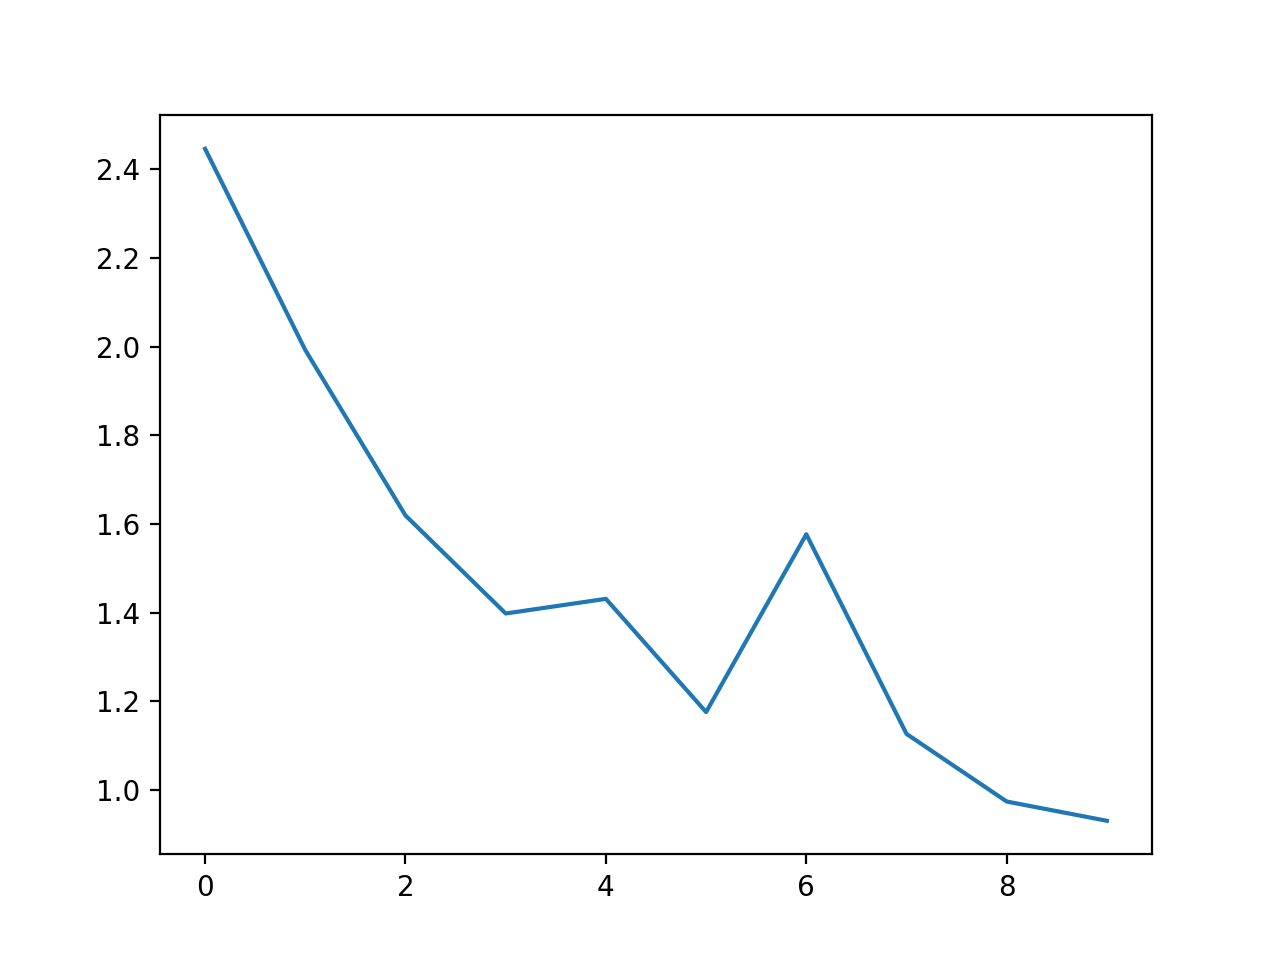

In [25]:
%matplotlib notebook
plt.plot(list(range(0,len(all_losses))),all_losses)
plt.show()

In [26]:
total = 0
right = 0
counter = 0
with torch.no_grad():
    for i, data in enumerate(test_loader, 0):
        counter = counter + 1
        inputs, labels = data[0].to(device), data[1].to(device)   
        output = rnn(inputs.float())
        guess, guess_i = categoryFromOutput(output)
        category = LABELS[int(labels[0])]
        
        if guess == category:
            right = right + 1


print('Accuracy of the network:  ',  (100 * right / counter))

Accuracy of the network:   62.5
